In [1]:
from dolfin import *
from ufl import le
import operator
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
if not os.path.exists("./Experiment1-Plots"):
    os.makedirs("./Experiment1-Plots")

In [2]:
# Q-Tensor parameters
n = 2
num_steps = 200
T = 2.0
dt = T/num_steps
a = -0.3
b = -4.
c = 4.
M = 1.
L = 1.

# Parameters for electric field
R = 1.
eps2 = 0.5
eps3 = 0.01
eps1 = 2.5

# Parameters for convex splitting
beta1 = 8.
beta2 = 8.

In [3]:
# Create mesh
mesh = RectangleMesh(Point(-0.5, -0.5), Point(0.5, 0.5), 30, 30)

In [4]:
# some functions for the scheme
I = Constant(np.eye(n)) # identity matrix
Zero = 0 * I
Zero_func = 0*Function(FunctionSpace(mesh, "Lagrange", 1))

def dF1_dQ(Q):
    Q2 = Q*Q
    trQ2 = tr(Q2)
    result = beta1 * Q - b*(Q2 - 1/n * trQ2 * I) + beta2 * trQ2 * Q
    return result

def dF2_dQ(Q):
    Q2 = Q*Q
    trQ2 = tr(Q2)
    result = (beta1 - a) * Q + (beta2 - c) * trQ2 * Q
    return result

def F_tot(Q):
    Q2 = Q*Q
    trQ2 = tr(Q2)
    trQ3 = tr(Q2*Q)
    result = a/2 * trQ2 - b/3 * trQ3 + c/4 * trQ2**2
    return result

def tens(Q):
    """
    Make vector function with two components into tensor
    """
    return as_tensor([[Q[0], Q[1]],
                      [Q[1], -1*Q[0]]])

def tens_hi(Q):
    return as_tensor([[Q[0], Q[1]],
                      [Zero_func, Zero_func]])

def tens_lo(Q):
    return as_tensor([[Zero_func, Zero_func],
                      [Q[0], Q[1]]])

## Initialize $Q_h^0$ and $u_h^0$

In [5]:
# initial conditions for the Q tensor
class InitialConditions(UserExpression):
    def eval(self, values, x):
        x, y = x[0], x[1]
        if np.isclose(x, -0.5) or np.isclose(x, 0.5) or np.isclose(y, -0.5) or np.isclose(y, 0.5):
            values[0] = 0.0
            values[1] = 0.0
        else:
            n0 = (x+0.5)*(x-0.5)*(y+0.5)*(y-0.5)
            n1 = (x+0.5)*(x-0.5)*(y+0.5)*(y-0.5)
            d = np.array([[n0], [n1]]) # director
            Q0 = d @ d.T - np.sum(d*d)/2.0 * np.eye(2) # Q tensor

            values[0] = Q0[0, 0]
            values[1] = Q0[0, 1]
    def value_shape(self):
        return (2,)

In [6]:
# initialize Q tensor at time 0
Q0 = Function(VectorFunctionSpace(mesh, "Lagrange", 1, dim=2))
Q_init = InitialConditions()
Q0.interpolate(Q_init)

# define uninitialized u0 and linear form to solve for u0
u_space = FunctionSpace(mesh, "Lagrange", 1)
u0 = Function(u_space)
v = TestFunction(u_space)

L_elliptic = inner(grad(u0) + eps2*tens(Q0)*grad(u0) + eps3*div(tens(Q0)), grad(v))*dx

# define boundary condition for u0
t = 0.0
u_b = Expression(f'10*sin({2*np.pi*t+0.2})*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)
bc_u = DirichletBC(u_space, u_b, DomainBoundary())

# solve for u0
solve(L_elliptic == 0, u0, bc_u)

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.658e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.452e-14 (tol = 1.000e-10) r (rel) = 3.971e-16 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.


# Define and solve scheme

In [7]:
class QTensorEquation(NonlinearProblem):
    def __init__(self, L, a, bcs):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
        self.bcs = bcs
    def F(self, b, x):
        assemble(self.L, tensor=b)
        for bc in self.bcs:
            bc.apply(b,x)
    def J(self, A, x):
        assemble(self.a, tensor=A)
        for bc in self.bcs:
            bc.apply(A)

In [8]:
Q_space = VectorElement("Lagrange", mesh.ufl_cell(), 1, dim=2)
u_space = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
ME = MixedElement(Q_space, u_space)
V = FunctionSpace(mesh, ME)

In [9]:
# Define trial and test functions
dQu = TrialFunction(V)
q, v = TestFunctions(V)
r, _ = TestFunctions(V)

# Define functions
Qu = Function(V)

# Split mixed functions
dQ, du = split(dQu)
Q, u = split(Qu)

In [10]:
# Weak statement of the equation
# Note that we manually make trace free symmetric tensors
# using vector function spaces instead of using tensor functions
L_form = inner(tens(Q - Q0), tens_hi(q))*dx\
    + M*L*dt/2*inner(grad(tens(Q+Q0)), grad(tens_hi(q)))*dx\
    + M*dt*inner(dF1_dQ(tens(Q)), tens_hi(q))*dx\
    - M*dt*inner(dF2_dQ(tens(Q0)), tens_hi(q))*dx\
    - M*eps2*dt/2*inner(outer(grad(u0), grad(u)) - (1/n)*tr(outer(grad(u0), grad(u)))*I, tens_hi(q))*dx\
    - M*eps3*dt/2*(inner(grad(u+u0), div(sym(tens_hi(q))))*dx - (1/n)*inner(grad(u+u0), grad(tr(tens_hi(q))))*dx)\
    + inner(tens(Q - Q0), tens_lo(r))*dx\
    + M*L*dt/2*inner(grad(tens(Q+Q0)), grad(tens_lo(r)))*dx\
    + M*dt*inner(dF1_dQ(tens(Q)), tens_lo(r))*dx\
    - M*dt*inner(dF2_dQ(tens(Q0)), tens_lo(r))*dx\
    - M*eps2*dt/2*inner(outer(grad(u0), grad(u)) - (1/n)*tr(outer(grad(u0), grad(u)))*I, tens_lo(r))*dx\
    - M*eps3*dt/2*(inner(grad(u+u0), div(sym(tens_lo(r))))*dx - (1/n)*inner(grad(u+u0), grad(tr(tens_lo(r))))*dx)\
    + inner(grad(u) + eps2*tens(Q)*grad(u) + eps3*div(tens(Q)), grad(v))*dx

a_form = derivative(L_form, Qu, dQu)

In [11]:
# boundary conditions for Q do not change
bc_Q = DirichletBC(V.sub(0), np.zeros(2), DomainBoundary())

# Store solutions and times
Q_array = Q0.vector()[:].reshape(-1, 2)
Q_11 = Q_array[:, 0]
Q_12 = Q_array[:, 1]
solutions_Q = [np.array([[Q_11, Q_12], [Q_12, -Q_11]]).transpose(2, 0, 1)]
solutions_u = [np.array(u0.vector()[:].reshape(-1, 1))]
times = [0.0]

solver = NewtonSolver()

t = 0.0
while (t < T):
    print(t)
    t += dt
    times.append(t)
    
    u_b = Expression(f'10*sin({2*np.pi*t+0.2})*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)
    bc_u = DirichletBC(V.sub(1), u_b, DomainBoundary())
    
    problem = QTensorEquation(L_form, a_form, [bc_Q, bc_u])
    solver.solve(problem, Qu.vector())
    
    Q_array = Qu.sub(0, deepcopy=True).vector()[:].reshape(-1, 2)
    Q_11 = Q_array[:, 0]
    Q_12 = Q_array[:, 1]
    
    solutions_Q.append(np.array([[Q_11, Q_12], [Q_12, -Q_11]]).transpose(2, 0, 1))
    solutions_u.append(np.array(Qu.sub(1, deepcopy=True).vector()[:].reshape(-1, 1)))
    
    Q0.vector()[:] = np.ascontiguousarray(Qu.sub(0, deepcopy=True).vector()[:])
    u0.vector()[:] = np.ascontiguousarray(Qu.sub(1, deepcopy=True).vector()[:])

0.0
Newton iteration 0: r (abs) = 1.537e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 3.264e-03 (tol = 1.000e-10) r (rel) = 2.123e-04 (tol = 1.000e-09)
0.01
Newton iteration 2: r (abs) = 1.278e-08 (tol = 1.000e-10) r (rel) = 8.312e-10 (tol = 1.000e-09)
Newton solver finished in 2 iterations and 2 linear solver iterations.
Newton iteration 0: r (abs) = 3.557e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
0.02
Newton iteration 1: r (abs) = 7.541e-04 (tol = 1.000e-10) r (rel) = 2.120e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 2.095e-09 (tol = 1.000e-10) r (rel) = 5.889e-10 (tol = 1.000e-09)
Newton solver finished in 2 iterations and 2 linear solver iterations.
Newton iteration 0: r (abs) = 3.483e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 8.450e-04 (tol = 1.000e-10) r (rel) = 2.426e-04 (tol = 1.000e-09)
0.03
Newton iteration 2: r (abs) = 2.399e-09 (tol = 1.000e-10) r (rel) = 6.8

Newton iteration 1: r (abs) = 1.082e-04 (tol = 1.000e-10) r (rel) = 2.007e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 1.328e-09 (tol = 1.000e-10) r (rel) = 2.463e-09 (tol = 1.000e-09)
0.20000000000000004
Newton iteration 3: r (abs) = 2.054e-14 (tol = 1.000e-10) r (rel) = 3.809e-14 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
Newton iteration 0: r (abs) = 3.072e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 4.956e-05 (tol = 1.000e-10) r (rel) = 1.613e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 7.116e-10 (tol = 1.000e-10) r (rel) = 2.316e-09 (tol = 1.000e-09)
0.21000000000000005
Newton iteration 3: r (abs) = 2.202e-14 (tol = 1.000e-10) r (rel) = 7.167e-14 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
Newton iteration 0: r (abs) = 7.401e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 1.477e-05 (tol = 1.0

0.4100000000000002
Newton iteration 2: r (abs) = 2.864e-08 (tol = 1.000e-10) r (rel) = 8.355e-09 (tol = 1.000e-09)
Newton iteration 3: r (abs) = 7.589e-15 (tol = 1.000e-10) r (rel) = 2.214e-15 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
Newton iteration 0: r (abs) = 3.512e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 1.345e-03 (tol = 1.000e-10) r (rel) = 3.830e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 2.450e-08 (tol = 1.000e-10) r (rel) = 6.977e-09 (tol = 1.000e-09)
Newton iteration 3: r (abs) = 6.606e-15 (tol = 1.000e-10) r (rel) = 1.881e-15 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
0.4200000000000002
Newton iteration 0: r (abs) = 3.581e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 1.271e-03 (tol = 1.000e-10) r (rel) = 3.548e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 1.961e-08 (tol = 1.000

Newton iteration 1: r (abs) = 1.155e-03 (tol = 1.000e-10) r (rel) = 4.447e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 2.238e-08 (tol = 1.000e-10) r (rel) = 8.612e-09 (tol = 1.000e-09)
0.6000000000000003
Newton iteration 3: r (abs) = 1.555e-14 (tol = 1.000e-10) r (rel) = 5.984e-15 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
Newton iteration 0: r (abs) = 2.426e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 1.085e-03 (tol = 1.000e-10) r (rel) = 4.472e-04 (tol = 1.000e-09)
0.6100000000000003
Newton iteration 2: r (abs) = 2.223e-08 (tol = 1.000e-10) r (rel) = 9.162e-09 (tol = 1.000e-09)
Newton iteration 3: r (abs) = 1.752e-14 (tol = 1.000e-10) r (rel) = 7.220e-15 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
Newton iteration 0: r (abs) = 2.244e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 9.919e-04 (tol = 1.000

Newton iteration 0: r (abs) = 2.312e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 8.255e-04 (tol = 1.000e-10) r (rel) = 3.571e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 1.304e-08 (tol = 1.000e-10) r (rel) = 5.639e-09 (tol = 1.000e-09)
Newton iteration 3: r (abs) = 1.464e-14 (tol = 1.000e-10) r (rel) = 6.333e-15 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
0.8300000000000005
Newton iteration 0: r (abs) = 2.490e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 9.501e-04 (tol = 1.000e-10) r (rel) = 3.815e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 1.746e-08 (tol = 1.000e-10) r (rel) = 7.012e-09 (tol = 1.000e-09)
0.8400000000000005
Newton iteration 3: r (abs) = 1.430e-14 (tol = 1.000e-10) r (rel) = 5.743e-15 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
Newton iteration 0: r (abs) = 2.658e+00 (tol = 1.000

1.0400000000000007
Newton iteration 2: r (abs) = 1.919e-09 (tol = 1.000e-10) r (rel) = 5.511e-10 (tol = 1.000e-09)
Newton solver finished in 2 iterations and 2 linear solver iterations.
Newton iteration 0: r (abs) = 3.394e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 9.144e-04 (tol = 1.000e-10) r (rel) = 2.694e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 3.637e-09 (tol = 1.000e-10) r (rel) = 1.072e-09 (tol = 1.000e-09)
Newton iteration 3: r (abs) = 9.730e-15 (tol = 1.000e-10) r (rel) = 2.867e-15 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
Newton iteration 0: r (abs) = 3.292e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 1.035e-03 (tol = 1.000e-10) r (rel) = 3.145e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 6.086e-09 (tol = 1.000e-10) r (rel) = 1.849e-09 (tol = 1.000e-09)
1.0500000000000007
Newton iteration 3: r (abs) = 1.076e-14 (tol = 1.000

1.2400000000000009
Newton iteration 2: r (abs) = 6.631e-11 (tol = 1.000e-10) r (rel) = 1.690e-10 (tol = 1.000e-09)
Newton solver finished in 2 iterations and 2 linear solver iterations.
Newton iteration 0: r (abs) = 6.237e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 4.640e-05 (tol = 1.000e-10) r (rel) = 7.440e-05 (tol = 1.000e-09)
1.2500000000000009
Newton iteration 2: r (abs) = 3.374e-11 (tol = 1.000e-10) r (rel) = 5.409e-11 (tol = 1.000e-09)
Newton solver finished in 2 iterations and 2 linear solver iterations.
Newton iteration 0: r (abs) = 8.526e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 9.128e-05 (tol = 1.000e-10) r (rel) = 1.071e-04 (tol = 1.000e-09)
1.260000000000001
Newton iteration 2: r (abs) = 1.128e-10 (tol = 1.000e-10) r (rel) = 1.323e-10 (tol = 1.000e-09)
Newton solver finished in 2 iterations and 2 linear solver iterations.
Newton iteration 0: r (abs) = 1.078e+00 (tol = 1.000e-10) r

1.450000000000001
Newton iteration 2: r (abs) = 9.953e-09 (tol = 1.000e-10) r (rel) = 2.706e-09 (tol = 1.000e-09)
Newton iteration 3: r (abs) = 2.228e-15 (tol = 1.000e-10) r (rel) = 6.057e-16 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
Newton iteration 0: r (abs) = 3.704e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 8.762e-04 (tol = 1.000e-10) r (rel) = 2.365e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 6.136e-09 (tol = 1.000e-10) r (rel) = 1.656e-09 (tol = 1.000e-09)
1.460000000000001
Newton iteration 3: r (abs) = 1.025e-15 (tol = 1.000e-10) r (rel) = 2.766e-16 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
Newton iteration 0: r (abs) = 3.716e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 7.078e-04 (tol = 1.000e-10) r (rel) = 1.904e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 3.348e-09 (tol = 1.000e-

Newton iteration 3: r (abs) = 1.807e-14 (tol = 1.000e-10) r (rel) = 1.257e-14 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
Newton iteration 0: r (abs) = 1.219e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 3.889e-04 (tol = 1.000e-10) r (rel) = 3.191e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 5.423e-09 (tol = 1.000e-10) r (rel) = 4.450e-09 (tol = 1.000e-09)
Newton iteration 3: r (abs) = 1.988e-14 (tol = 1.000e-10) r (rel) = 1.631e-14 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
1.6700000000000013
Newton iteration 0: r (abs) = 9.959e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 2.799e-04 (tol = 1.000e-10) r (rel) = 2.810e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 3.586e-09 (tol = 1.000e-10) r (rel) = 3.601e-09 (tol = 1.000e-09)
Newton iteration 3: r (abs) = 2.042e-14 (tol = 1.000e-10) r (rel) = 2.0

Newton iteration 1: r (abs) = 1.068e-03 (tol = 1.000e-10) r (rel) = 4.016e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 2.208e-08 (tol = 1.000e-10) r (rel) = 8.306e-09 (tol = 1.000e-09)
1.8500000000000014
Newton iteration 3: r (abs) = 1.418e-14 (tol = 1.000e-10) r (rel) = 5.335e-15 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
Newton iteration 0: r (abs) = 2.816e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 1.174e-03 (tol = 1.000e-10) r (rel) = 4.168e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 2.644e-08 (tol = 1.000e-10) r (rel) = 9.387e-09 (tol = 1.000e-09)
1.8600000000000014
Newton iteration 3: r (abs) = 1.252e-14 (tol = 1.000e-10) r (rel) = 4.444e-15 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
Newton iteration 0: r (abs) = 2.963e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 1.264e-03 (tol = 1.000

# Visualize solution

In [12]:
solutions_u = np.array(solutions_u)
solutions_Q = np.array(solutions_Q) # time x mesh size x rows x cols

In [13]:
# turn solutions into time series of vector field and use plot command from FEniCS
directors = np.zeros((solutions_Q.shape[0], solutions_Q.shape[1], 2, 1))
for time in range(solutions_Q.shape[0]):
    for point in range(solutions_Q.shape[1]):
        Q_tensor = solutions_Q[time, point]
        eigenvalues, eigenvectors = np.linalg.eigh(Q_tensor)
        v1 = eigenvectors[:, 0]
        v2 = eigenvectors[:, 1]
        if np.sum(np.abs(Q_tensor)) > 1e-6:
            director1x = v1[0]
            director1y = v1[1]
            director2x = v2[0]
            director2y = v2[1]
            directors[time, point] = v2.reshape(-1, 1)
        else:
            directors[time, point] = np.zeros((2, 1))

0.00


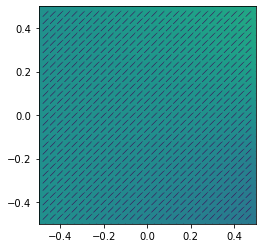

0.01


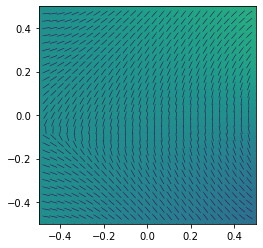

0.02


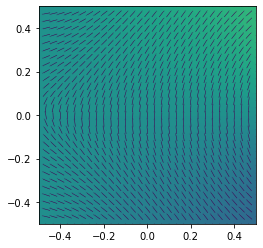

0.03


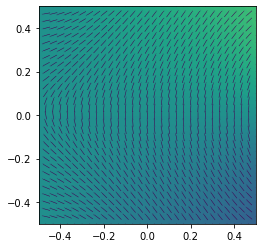

0.04


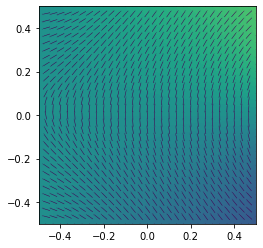

0.05


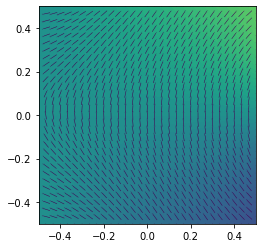

0.06


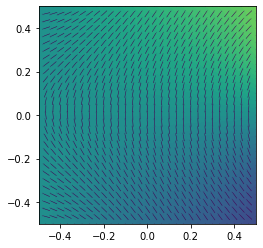

0.07


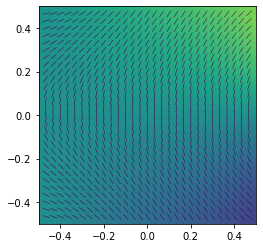

0.08


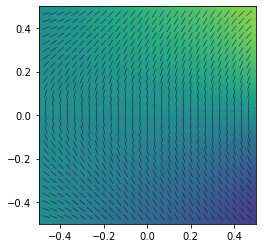

0.09


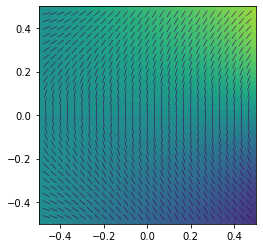

0.10


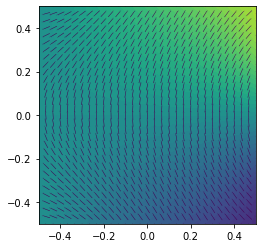

0.11


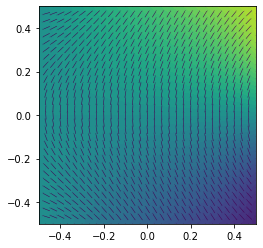

0.12


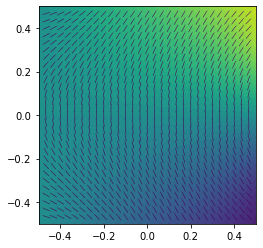

0.13


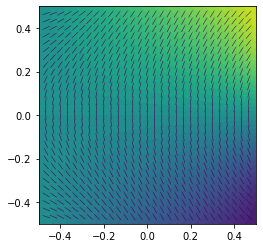

0.14


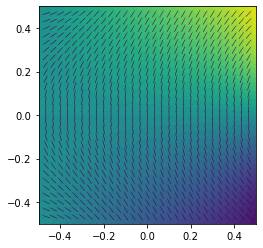

0.15


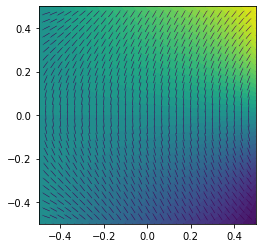

0.16


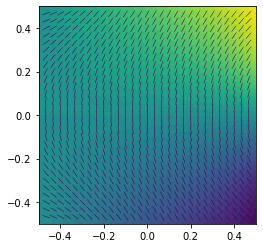

0.17


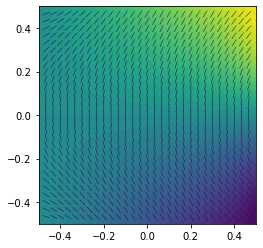

0.18


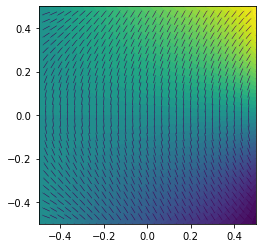

0.19


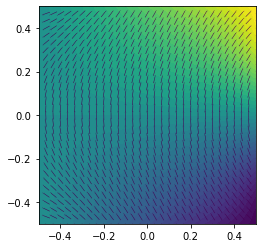

0.20


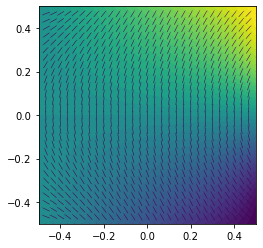

0.21


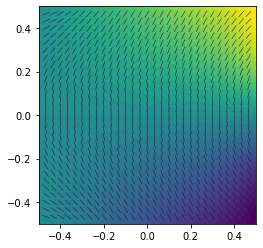

0.22


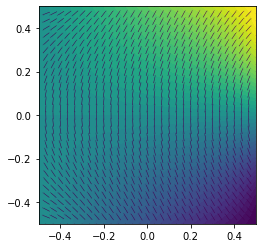

0.23


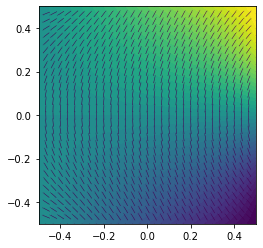

0.24


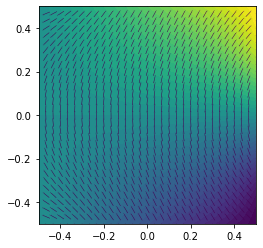

0.25


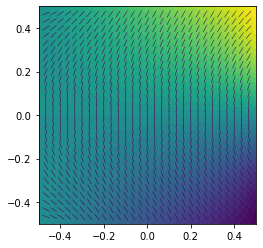

0.26


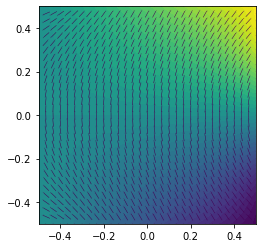

0.27


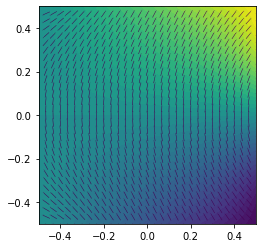

0.28


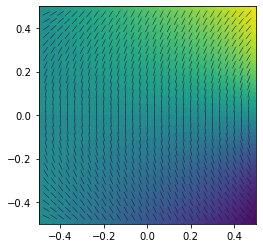

0.29


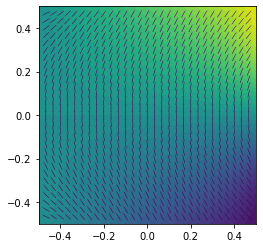

0.30


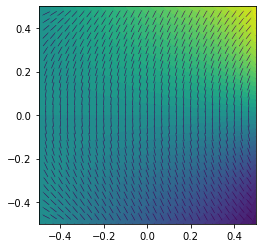

0.31


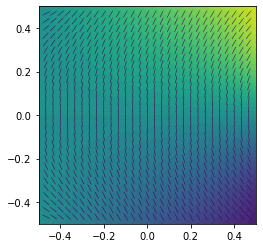

0.32


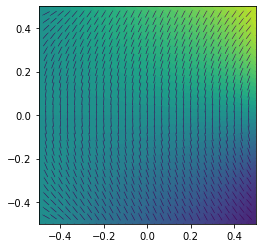

0.33


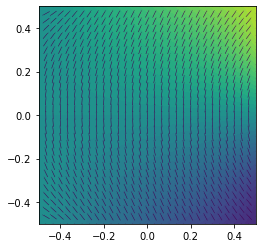

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [24]:
DirectorSpace = VectorFunctionSpace(mesh, "Lagrange", 1, dim=n)
D0 = Function(DirectorSpace)
u1 = Function(FunctionSpace(mesh, "Lagrange", 1))
for time in range(directors.shape[0]):
    fig, ax = plt.subplots(1, 1)
    
    u1.vector()[:] = np.ascontiguousarray(solutions_u[time].reshape(-1))
    out = plot(u1, vmin=np.min(solutions_u), vmax=np.max(solutions_u))
    
    D0.vector()[:] = np.ascontiguousarray(directors[time].reshape(-1))
    out = plot(D0, scale=25., pivot='mid', clim=(0., 0.), headaxislength=0)
    
    fraction = 1  # .05
    norm = mpl.colors.Normalize(vmin=np.min(solutions_u), vmax=np.max(solutions_u))
    if abs(time*dt - 2) <= 1e-4:
        cbar = ax.figure.colorbar(mpl.cm.ScalarMappable(norm=norm), ax=out.ax)
    
    print(f"{times[time]:.2f}")
    if abs(time*dt - 0) <= 1e-4 or abs(time*dt - 0.25) <= 1e-4 or abs(time*dt - 0.5) <= 1e-4\
        or abs(time*dt - 0.75) <= 1e-4 or abs(time*dt - 1) <= 1e-4 or abs(time*dt - 1.25) <= 1e-4\
        or abs(time*dt - 1.5) <= 1e-4 or abs(time*dt - 1.75) <= 1e-4 or abs(time*dt - 2) <= 1e-4:
        plt.savefig(f"./Experiment1-Plots/experiment1_{time}.png", bbox_inches='tight')
    plt.show()

# Look at eigenvalues and entries of Q tensors

In [15]:
eigenvalue_1 = []
eigenvalue_2 = []
for time_i in range(solutions_Q.shape[0]):
    eigenvalue_1.append([])
    eigenvalue_2.append([])
    for vertex in range(solutions_Q.shape[1]):
        w, v = np.linalg.eigh(solutions_Q[time_i, vertex])
        eigenvalue_1[-1].append(w[0])
        eigenvalue_2[-1].append(w[1])

In [16]:
max_entries_tQ = []
max_entries_t = []
for time_i in range(solutions_Q.shape[0]):
    max_entries_tQ.append([])
    for vertex in range(solutions_Q.shape[1]):
        max_entries_tQ[-1].append(np.max(np.abs(solutions_Q[time_i, vertex])))
    max_entries_t.append(np.max(max_entries_tQ[-1]))

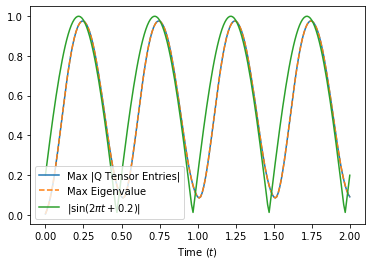

In [17]:
plt.plot(np.arange(len(max_entries_t))*dt, max_entries_t, label='Max |Q Tensor Entries|')
plt.plot(np.arange(len(eigenvalue_2))*dt, np.max(eigenvalue_2, axis=1), linestyle='--', label='Max Eigenvalue')
plt.plot(np.arange(len(max_entries_t))*dt, np.abs(np.sin(2*np.pi*np.arange(len(max_entries_t))*dt+0.2)), label='$|\sin(2\pi t+0.2)|$')
plt.xlabel("Time ($t$)")
plt.legend()
plt.savefig("./Experiment1-Plots/experiment1_eigenvalues.png", bbox_inches='tight')
plt.show()